In [3]:
library(tidyverse)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



# Generate Simulated Data Set

In [1]:
library(tidyverse)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [10]:
#library(devtools)
#install_github("theodds/SoftBART")

## Functions used to generate fake data
set.seed(42)
f_fried <- function(x) 10 * sin(pi * x[,1] * x[,2]) + 20 * (x[,3] - 0.5)^2 + 
  10 * x[,4] + 5 * x[,5]

our_function <- function(x) sin(x[,1])*exp(x[,2])*10 + cos(2*x[,3]) - 20*x[,4]^2 + 3*x[,5]^3 - 15*x[,6]^(1/3) 

high_dimensional_func <- function(x) 10 * sin(pi * apply(x[,1:200], 1, prod)) + 20 * (apply(x[,201:300],1,sum) - 5)^2 + 
  10 * apply(x[,301:400],1,sum) + 5 * apply(x[,401:500],1,sum)

gen_data <- function(n_train, n_test, func, P, sigma, a, b) {
  X <- matrix(runif(n_train * P, a, b), nrow = n_train)
  mu <- func(X)
  X_test <- matrix(runif(n_test * P, a, b), nrow = n_test)
  mu_test <- func(X_test)
  Y <- mu + sigma * rnorm(n_train)
  Y_test <- mu_test + sigma * rnorm(n_test)
  
  return(list(X = X, Y = Y, mu = mu, X_test = X_test, Y_test = Y_test, mu_test = mu_test))
}

set.seed(42)
# only 5 predictors are important out of 20
sim_data_sparse <- gen_data(250, 100, f_fried, 20, 1, 0, 1)
sim_data <- sim_data_sparse

In [11]:
sim_data$X %>% head
sim_data$Y %>% head

0.9148060,0.33423133,0.1365052,0.24492099,0.84829322,0.73592037,0.05391100,0.1651787,0.9899656,0.24640458,0.06038098,0.4088231,0.2737925,0.3133691,0.19940178,0.8555082,0.59892983,0.3641020,0.29991068,0.5124174
0.9370754,0.18843433,0.1771364,0.08763591,0.06274633,0.75178575,0.95509577,0.7277811,0.4384936,0.02302811,0.93300437,0.3158619,0.9441967,0.6887178,0.56649540,0.2165558,0.96894761,0.4326160,0.07423252,0.4984634
0.2861395,0.26971618,0.5195605,0.39110850,0.81984509,0.33261448,0.02560094,0.2061579,0.6999032,0.28421418,0.34894162,0.4947276,0.4459833,0.5323920,0.16805282,0.3174699,0.39053533,0.7288679,0.92831706,0.1367773
0.8304476,0.53074408,0.8111208,0.18256143,0.53936029,0.05754862,0.92076314,0.5864655,0.8890770,0.81289268,0.41179789,0.6489300,0.5417872,0.7599945,0.94363115,0.5413980,0.85281451,0.2627979,0.40114898,0.4507146
0.6417455,0.02145023,0.1153620,0.13362478,0.49902010,0.67441545,0.36666474,0.9135460,0.8341595,0.71891839,0.96114648,0.6498625,0.1617545,0.6498432,0.50440809,0.4303394,0.04228755,0.7689716,0.66537518,0.3133368
0.5190959,0.79876031,0.8934218,0.25746291,0.02222732,0.04157017,0.69839255,0.2069666,0.7344215,0.52957674,0.53107291,0.5023026,0.6930535,0.4968844,0.04706947,0.3649031,0.42472235,0.5102272,0.02496750,0.7338139


[1] 17.818824  7.238283 10.304747 16.192667  7.100039 14.540596

# BART with 20 Predictors, 5 important

In [5]:
options(java.parameters = "-Xmx8g")
library(bartMachine)

Loading required package: rJava
Loading required package: bartMachineJARs
Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: missForest
Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.3! You have 7.64GB memory available.

If you run out of memory, restart R, and use e.g.
'options(java.parameters = "-Xmx5g")' for 5GB of RAM b

In [6]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

[1] 16


In [7]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [8]:
t.start <- Sys.time()
sim.bm <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine initializing with 50 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 21 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for regression ...
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 3.669623 secs


In [9]:
k_fold_cv(X = sim_data$X %>% data.frame, y = sim_data$Y,)

.....


$y_hat
  [1] 16.218246 10.007319 11.769000 16.535638  6.072252 17.063996 12.408267
  [8] 10.694791 22.522986 23.604444 20.980424 14.314518  9.288236  7.658737
 [15] 15.500300 14.752596 19.192104  6.827830 16.894040 14.699382 16.175560
 [22]  7.745880 16.036886  9.959340 11.809504  8.340950 20.164825 21.400648
 [29] 19.655013 23.441409 21.769057 12.669623  8.139748 11.724040 11.563407
 [36] 10.769182 12.313250  9.336080 14.534892  2.958018 21.393355 17.099217
 [43]  9.337565 12.959728 15.375865  7.716772 16.408469 16.101027 18.564179
 [50]  2.328639 21.565409 16.828967  3.273427 18.464711 12.442062 19.077389
 [57] 19.021458  6.583270  9.305667 13.001818  5.747342 21.928872 16.249798
 [64] 11.257075 15.776872 16.066273 18.737827 12.968916 12.407924 15.666929
 [71]  8.543764  9.130891 10.161325 12.847160  7.816644 20.436172 10.468872
 [78] 12.256922 10.609176  3.800961 13.690359 11.176143  5.468804 15.252964
 [85] 20.581196 14.849025 15.025670 15.987896 15.675133  5.183739 19.096167
 [92]  8.629858 10.356003 19.003567 10.268295  7.191414 12.948390  9.638005
 [99] 25.492237 14.267717 11.880359 16.583448  7.473734  8.287378 16.898575
[106] 12.800291 20.830833 22.954828 15.701395 14.171489 21.272958 17.679157
[113] 14.499888 14.122599 14.528551 20.849239  9.240155 14.909327 12.156523
[120] 14.338728 12.742844 18.205375 14.486053 13.465513 19.497485 19.108745
[127]  9.982698 10.326772 10.502894 17.212243 19.289206 20.170640 18.017316
[134] 16.919183 21.766896 13.082971 10.914957  4.535083 18.440606 14.421690
[141]  9.596615 13.777220 17.655026 15.132728 14.118675 18.842600  7.123656
[148]  8.807036 19.509752  8.970279  7.533124 11.341746 20.872048 10.288461
[155] 16.922113 17.824471 11.770535  8.084724  8.138240 10.255282 12.718969
[162] 16.709782 16.846443 19.528513 11.447751 10.618357 13.057568 14.042303
[169] 10.281644  4.445194 12.297008 21.350231 21.615160 14.394273 16.333452
[176] 10.856718 12.421617 15.698924 14.622446 16.953344 15.787234 21.756294
[183] 18.415656 14.135019 20.786323  8.527141 15.065961 14.482707  4.766253
[190] 16.459473 11.768659 18.745420  6.409909 10.660270 15.268351 10.013419
[197]  2.545589 14.863868 23.207387  4.924819 15.943032 14.690543 18.322332
[204] 18.191105 11.755002 17.985222 16.815778 18.879707 14.517010 16.779788
[211] 18.449905 16.830922  8.086379 10.579934  7.507628 23.201743  9.007436
[218]  8.544294 16.840134 15.784716 11.469670  6.507888 21.118050 16.035402
[225] 13.504567 16.970624 12.488561  8.783919 10.955680  9.136408 12.559650
[232]  8.503347 14.871816 12.859392 20.006621 14.759017 15.683102  9.948768
[239]  8.639846 13.032649 16.298561  9.542967 14.991025 19.449792 12.710956
[246]  8.287503 17.603819  6.799150 13.102689  7.414801

$L1_err
[1] 365.062

$L2_err
[1] 845.8242

$rmse
[1] 1.839374

$PseudoRsq
[1] 0.8732885

$folds
  [1] 2 3 4 5 3 1 3 5 1 4 4 2 3 4 4 1 3 1 3 1 5 4 4 3 5 3 5 3 2 2 2 5 2 3 5 2 2
 [38] 1 4 5 4 3 1 5 3 5 2 2 2 3 4 4 4 2 5 2 1 1 2 4 3 4 1 2 1 1 1 1 3 3 3 1 3 5
 [75] 5 1 4 1 4 3 4 5 2 1 3 5 4 5 1 4 4 1 1 2 2 1 2 4 3 2 4 1 5 5 2 3 5 5 5 4 1
[112] 1 2 5 3 4 4 5 2 5 2 5 2 1 2 2 2 5 1 4 3 5 3 4 5 3 5 4 2 5 1 4 1 5 3 1 1 1
[149] 5 1 5 3 5 5 2 5 4 4 3 1 5 4 1 5 4 5 4 4 5 1 3 2 4 2 2 3 1 2 1 1 1 4 2 4 2
[186] 2 3 1 3 4 2 5 5 4 2 3 4 1 1 5 2 5 4 4 3 1 5 3 1 5 4 1 4 4 2 4 1 1 4 3 3 3
[223] 3 3 2 2 3 2 1 3 3 5 2 2 3 5 3 2 3 5 2 4 4 1 3 2 3 5 3 2

In [10]:
sim.bm %>% summary

bartMachine v1.2.3 for regression

training data n = 250 and p = 20 
built in 2.9 secs on 16 cores, 50 trees, 250 burn-in and 1000 post. samples

sigsq est for y beforehand: 6.305 
avg sigsq estimate after burn-in: 1.50238 

in-sample statistics:
 L1 = 147.56 
 L2 = 132.33 
 rmse = 0.73 
 Pseudo-Rsq = 0.9802
p-val for shapiro-wilk test of normality of residuals: 0.81303 
p-val for zero-mean noise: 0.54588 



In [11]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [12]:
rmse(sim_data$Y, predict(sim.bm, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.bm, sim_data$X_test %>% data.frame)) #out of sample

[1] 0.7275446

[1] 1.430085

In [13]:
sim.bm %>% check_bart_error_assumptions

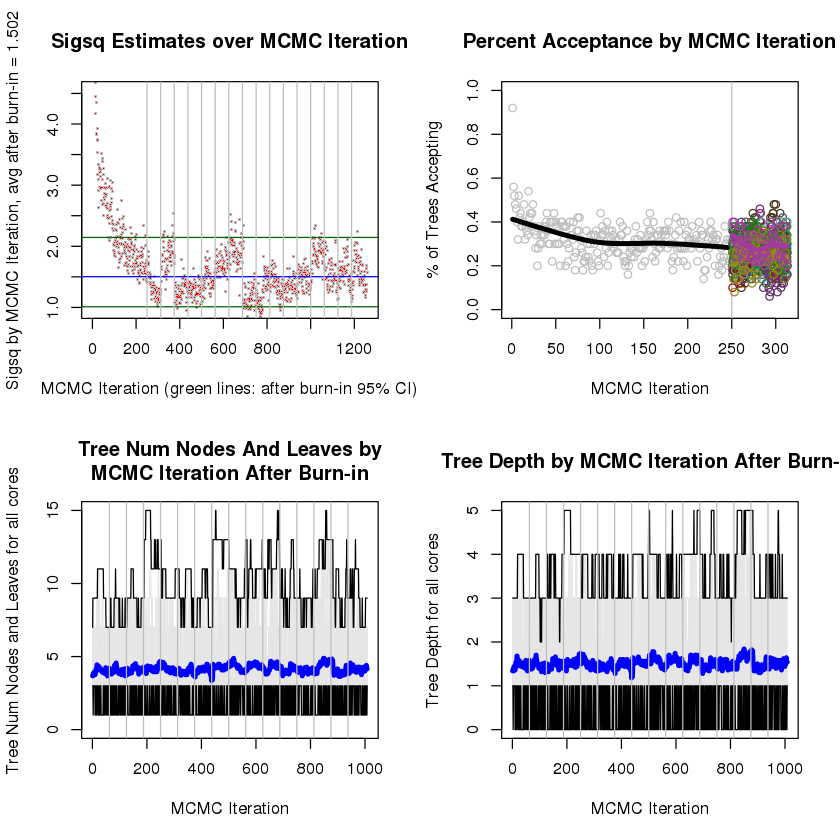

In [14]:
sim.bm %>% plot_convergence_diagnostics

....................


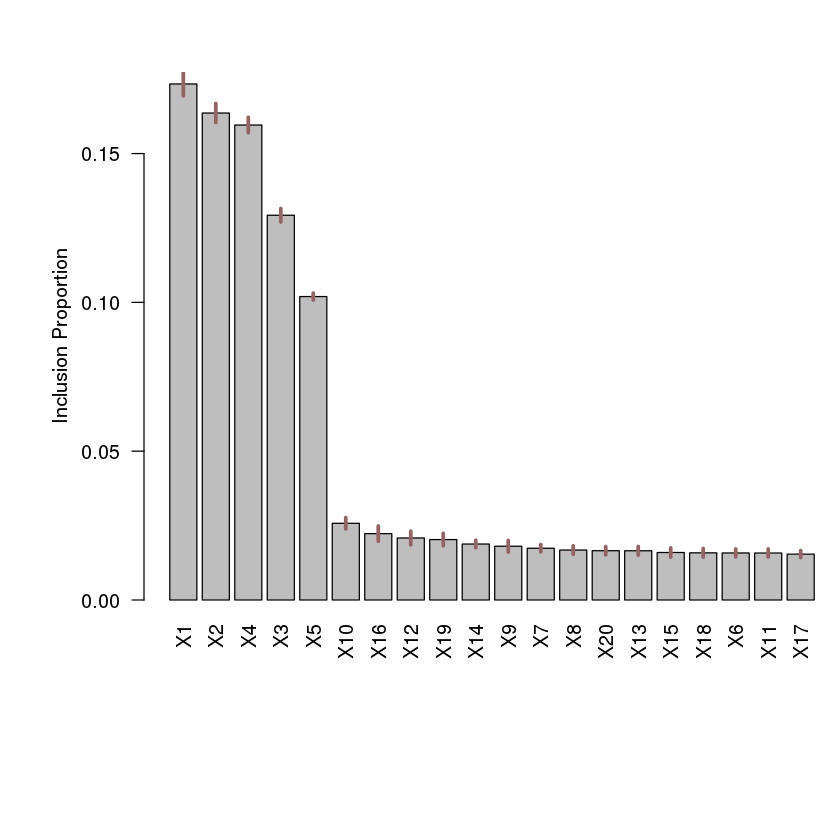

In [15]:
investigate_var_importance(sim.bm, num_replicates_for_avg = 20)

In [16]:
saveRDS(sim.bm,"model_files/simbm_sparse_model_v1_20191124.RDS")
sim.bm.read <- readRDS("model_files/simbm_sparse_model_v1_20191124.RDS")
sim.bm <- sim.bm.read

# DART with 20 Predictors, 5 important

In [12]:
options(java.parameters = "-Xmx8g")
library(dartMachine)

Loading required package: rJava
Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: missForest
Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.0! You have 7.64GB memory available.



In [13]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

[1] 16


In [14]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [15]:
t.start <- Sys.time()
sim.dartmachine <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine initializing with 50 trees...
Now building bartMachine for regression ...Covariate importance prior ON. 
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 10.36594 secs


In [16]:
sim.dartmachine %>% summary

bartMachine v1.2.0 for regression

training data n = 250 and p = 20 
built in 8.5 secs on 16 cores, 50 trees, 4000 burn-in and 4000 post. samples

sigsq est for y beforehand: 6.305 
avg sigsq estimate after burn-in: 0.90078 

in-sample statistics:
 L1 = 109.18 
 L2 = 72.22 
 rmse = 0.54 
 Pseudo-Rsq = 0.9892
p-val for shapiro-wilk test of normality of residuals: 0.15984 
p-val for zero-mean noise: 0.1905 



In [17]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [18]:
rmse(sim_data$Y, predict(sim.dartmachine, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.dartmachine, sim_data$X_test %>% data.frame)) #out of sample

[1] 0.5374646

[1] 1.240004

In [19]:
sim.dartmachine %>% check_bart_error_assumptions

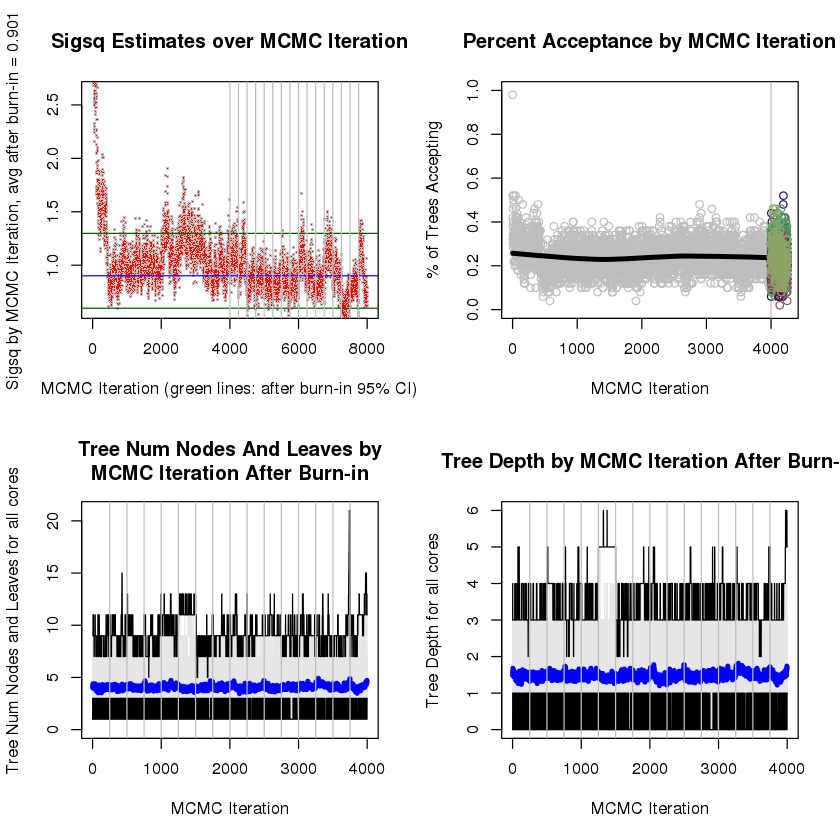

In [20]:
sim.dartmachine %>% plot_convergence_diagnostics

....................


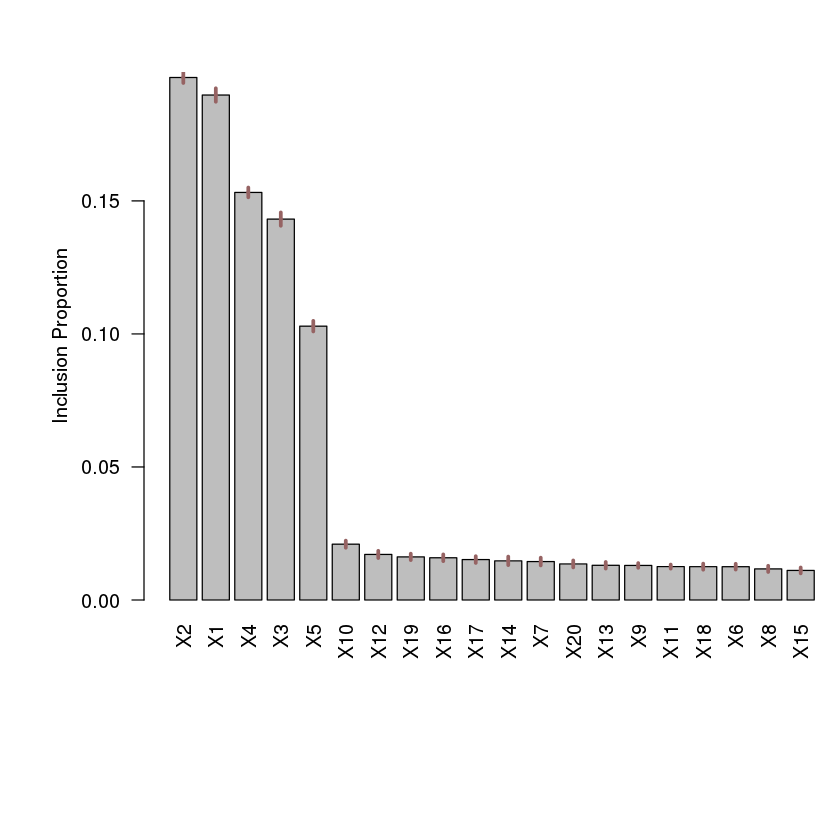

In [21]:
investigate_var_importance(sim.dartmachine, num_replicates_for_avg = 20)

In [23]:
#saveRDS(sim.dartmachine,"model_files/simdartMachine_sparse_model_v1_20191124.RDS")
sim.dartmachine.read <- readRDS("model_files/simdartMachine_sparse_model_v1_20191124.RDS")
sim.dartmachine <- sim.dartmachine.read

# SoftBART with 20 Predictors, 5 important

In [25]:
library(SoftBart)

Loading required package: scales

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: glmnet
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loaded glmnet 3.0-1

Loading required package: Rcpp


Finishing warmup 100 Number of trees = 50
Finishing warmup 200 Number of trees = 50
Finishing warmup 300 Number of trees = 50
Finishing warmup 400 Number of trees = 50
Finishing warmup 500 Number of trees = 50
Finishing warmup 600 Number of trees = 50
Finishing warmup 700 Number of trees = 50
Finishing warmup 800 Number of trees = 50
Finishing warmup 900 Number of trees = 50
Finishing warmup 1000 Number of trees = 50
Finishing warmup 1100 Number of trees = 50
Finishing warmup 1200 Number of trees = 50
Finishing warmup 1300 Number of trees = 50
Finishing warmup 1400 Number of trees = 50
Finishing warmup 1500 Number of trees = 50
Finishing warmup 1600 Number of trees = 50
Finishing warmup 1700 Number of trees = 50
Finishing warmup 1800 Number of trees = 50
Finishing warmup 1900 Number of trees = 50
Finishing warmup 2000 Number of trees = 50
Finishing warmup 2100 Number of trees = 50
Finishing warmup 2200 Number of trees = 50
Finishing warmup 2300 Number of trees = 50
Finishing warmup 240

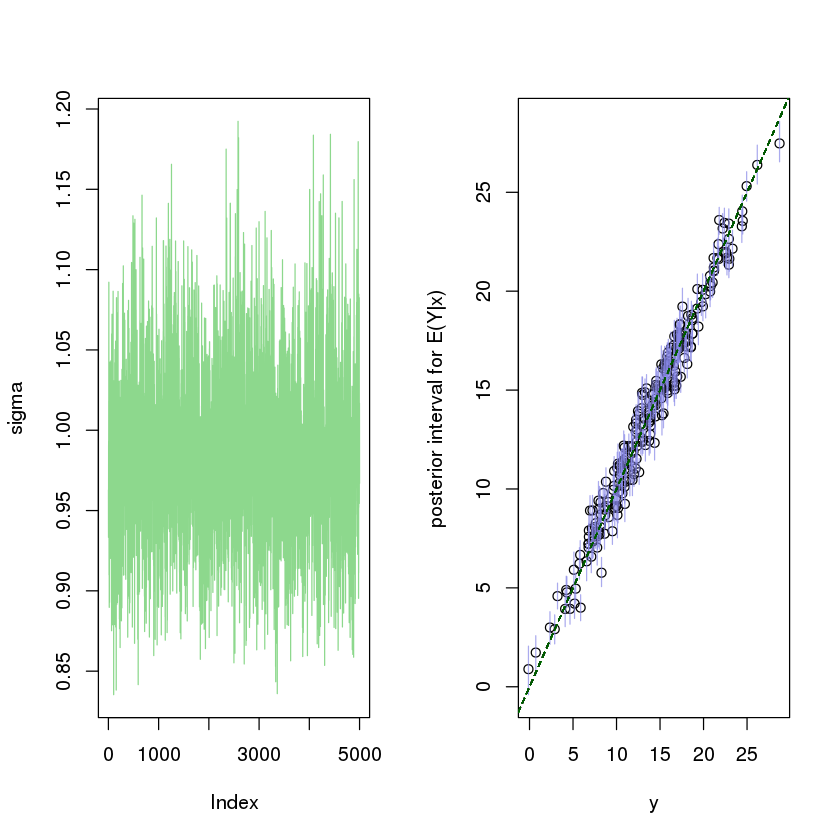

In [26]:
## Fit the models
softbart_fit_1 <- softbart(X = sim_data$X, Y = sim_data$Y, X_test = sim_data$X_test, 
                hypers = Hypers(sim_data$X, sim_data$Y, num_tree = 50, temperature = 1),
                opts = Opts(num_burn = 5000, num_save = 5000, update_tau = TRUE))

plot(softbart_fit_1)

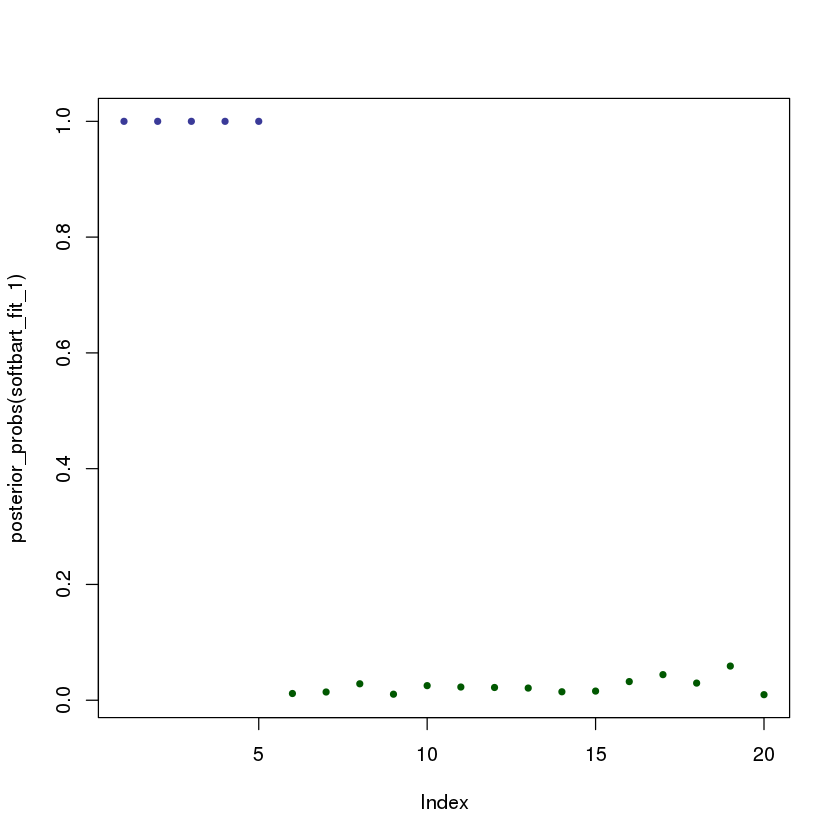

In [27]:
## Look at posterior model inclusion probabilities for each predictor. 

posterior_probs <- function(fit) colMeans(fit$var_counts > 0)
plot(posterior_probs(softbart_fit_1), 
     col = ifelse(posterior_probs(softbart_fit_1) > 0.5, muted("blue"), muted("green")), 
     pch = 20)

rmse <- function(x,y) sqrt(mean((x-y)^2))

In [28]:
rmse(softbart_fit_1$y_hat_train_mean, sim_data$Y)
rmse(softbart_fit_1$y_hat_test_mean, sim_data$Y_test)

[1] 0.8524532

[1] 1.051276

In [30]:
saveRDS(softbart_fit_1,file = "model_files/softbart_sparse_model_20191124.RDS")

In [33]:
softbart_fit_1.read = readRDS("model_files/softbart_sparse_model_20191124.RDS")
softbart_fit_1 <- softbart_fit_1.read